# P04 - MODELLING

In [70]:
from numpy import ndarray
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig, show, subplots
from ds_charts import multiple_line_chart, HEIGHT, plot_overfitting_study
from ts_functions import split_temporal_data, PREDICTION_MEASURES, plot_evaluation_results, create_temporal_dataset
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

%run p00_settings.ipynb

In [71]:
data_file = ts_transf_data_file if ts_transf else prepared_out_data_file
flat_data: DataFrame = read_csv(project_path + data_file, index_col=time_var, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)

In [72]:
if temporal_windows_df:
  data = create_temporal_dataset(flat_data[target], target, nr_instants, project_path + temp_window_data_file)
else:
  data = flat_data


In [73]:
y: ndarray = data.pop(target).values
X: ndarray = data.values
trnX, tstX, trnY, tstY = split_temporal_data(X, y, trn_pct=0.7)

## 01 - KNN

The adaptation of KNN to deal with predicition is straightforward, and resumes to predict the value to the average value of the target variable for its K nearest neighbors. In this context and in Python, they are implemented through the KNeighborsRegressor in the sklearn.neighbors.. And its use is similar for both classification and prediction.

As before, the number of neighbors to consider and the distance function to use to choose the neighbors, are given through n_neighbors and metric parameters. Note that in this context, weighting the influence of each neighbor according to its distance to the object to predict, might also be interesting, which may be done through the weights parameter.

In [74]:
measure = 'R2'
flag_pct = True
weights = ['uniform', 'distance']
dist = ['manhattan', 'euclidean', 'chebyshev']
kvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

<Figure size 600x450 with 0 Axes>

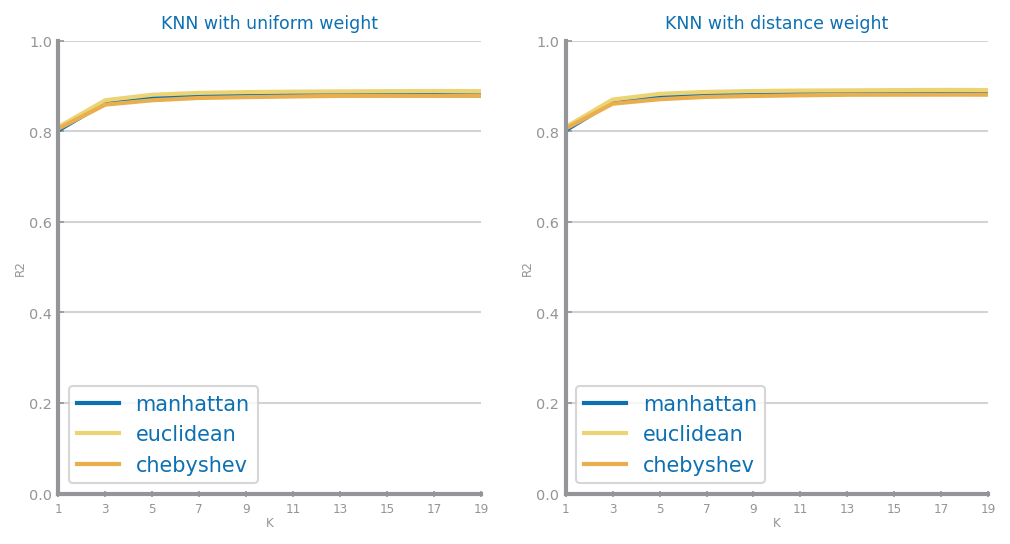

Best results achieved with distance weight, dist=euclidean and K=17 ==> measure=0.89


In [75]:
best = ('',  0, 0.0)
last_best = 0
best_model = None
ncols = len(weights)
figure()
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for wei in range(len(weights)):
    w = weights[wei]
    values = {}
    for d in dist:
        yvalues = []
        for k in kvalues:
            pred = KNeighborsRegressor(n_neighbors=k, metric=d, weights=w)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (w, d, k)
                last_best = yvalues[-1]
                best_model = pred

        values[d] = yvalues
    multiple_line_chart(
        kvalues, values, ax=axs[0, wei], title=f'KNN with {w} weight', xlabel='K', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_knn_study.png')
show()
print(f'Best results achieved with {best[0]} weight, dist={best[1]} and K={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.0, 0.339337128942638], 'MAE': [0.0, 0.21417645447516281]} {'MAPE': [0.0, 2.9489812090631156], 'R2': [1.0, 0.8909951055885543]}


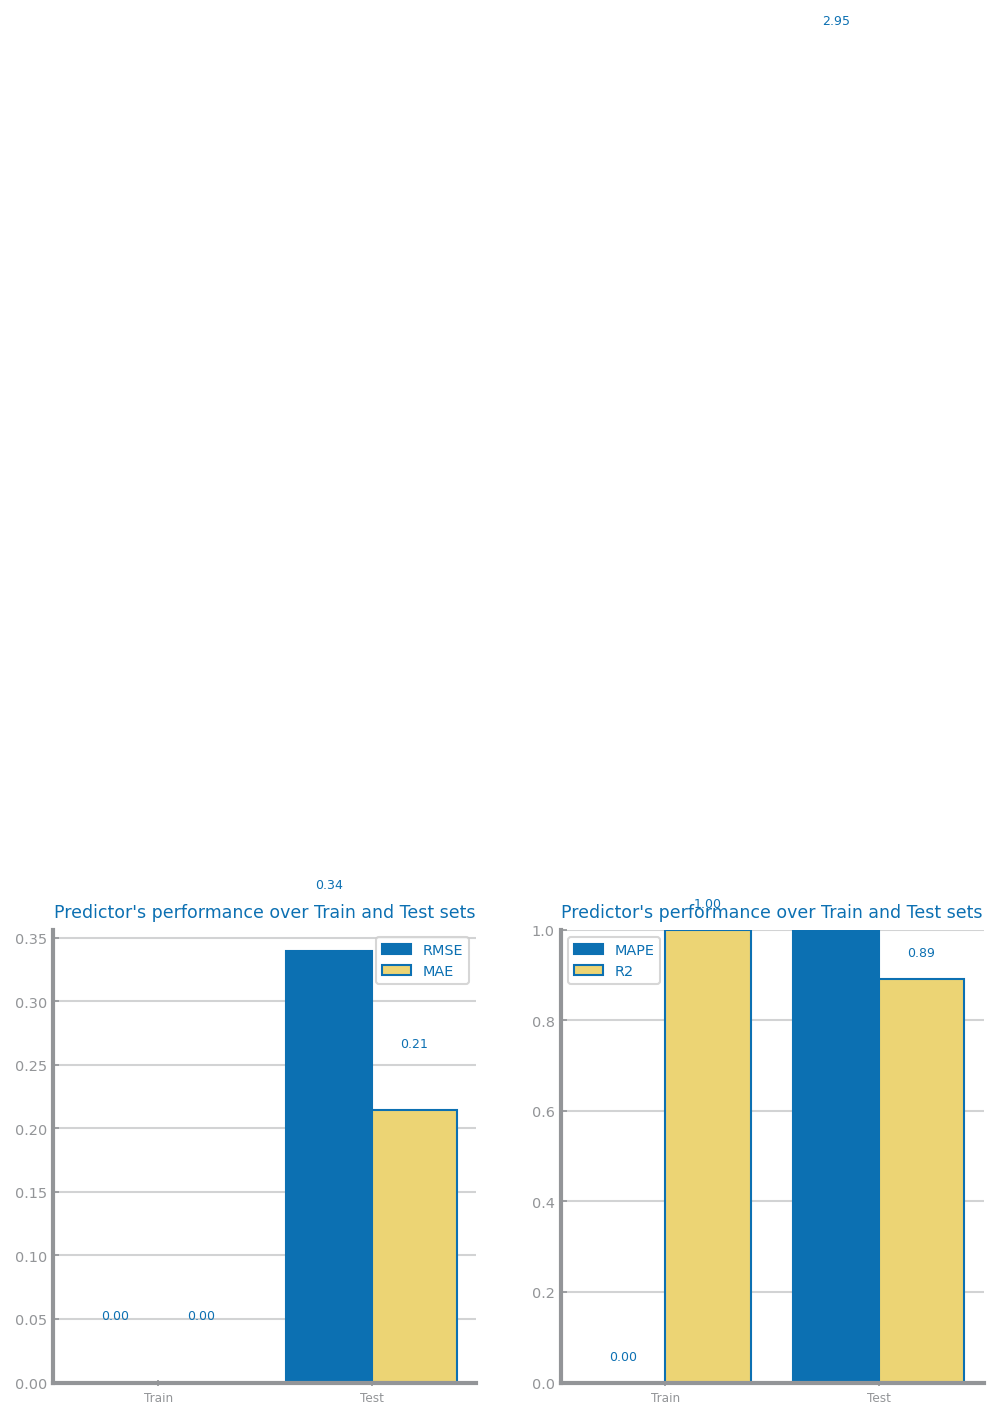

In [76]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_knn_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

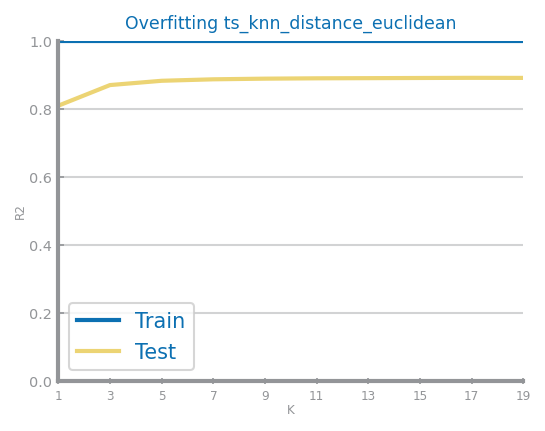

In [77]:
y_tst_values = []
y_trn_values = []
for k in kvalues:
    pred = KNeighborsRegressor(n_neighbors=k, metric=best[1], weights=best[0])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(kvalues, y_trn_values, y_tst_values, name=f'ts_knn_{best[0]}_{best[1]}', xlabel='K', ylabel=measure, pct=flag_pct)

## 02 - Regression Trees

Regression Trees are trees to deal with predicition. In this context and in Python, they are implemented through the DecisionTreeRegressor in the sklearn.tree. And its use is similar for both classification and prediction. Leafs on Regression Trees are just the average value of the target variable for the subset of training records reaching the leaf.

In [78]:
criteria = ['squared_error', 'friedman_mse', 'absolute_error']
max_depths = [2, 5, 7, 10, 12, 15, 17, 20, 22, 25]
min_impurity_decrease = [0.01, 0.001, 0.0001]

best = ('',  0, 0.0)
last_best = 0
best_model = None

measure = 'R2'
flag_pct = True

<Figure size 600x450 with 0 Axes>

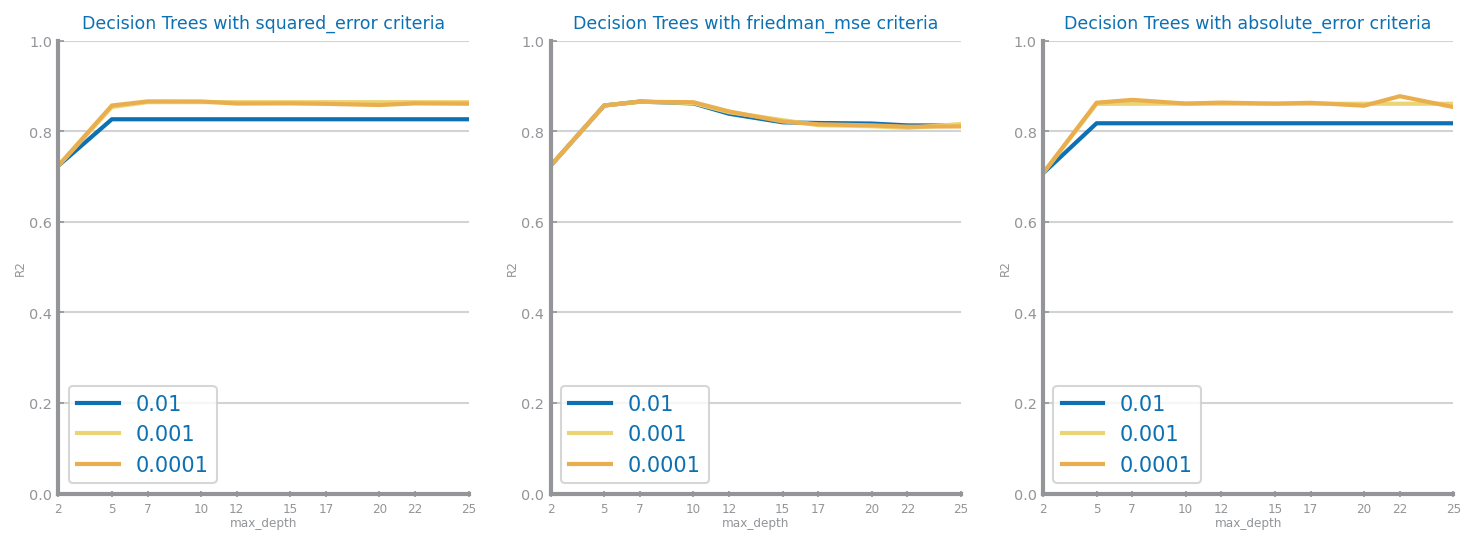

Best results achieved with absolute_error criteria, min_impurity_decrease=0.0001 and depth=22 ==> measure=0.88


In [79]:
ncols = len(criteria)
figure()
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(criteria)):
    crit = criteria[k]
    values = {}
    for imp in min_impurity_decrease:
        yvalues = []
        for d in max_depths:
            pred = DecisionTreeRegressor(max_depth=d, criterion=crit, min_impurity_decrease=imp)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (crit, imp, d)
                last_best = yvalues[-1]
                best_model = pred

        values[imp] = yvalues
    multiple_line_chart(
        max_depths, values, ax=axs[0, k], title=f'Decision Trees with {crit} criteria',
        xlabel='max_depth', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_dt_study.png')
show()
print(f'Best results achieved with {best[0]} criteria, min_impurity_decrease={best[1]} and depth={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.29936900769037866, 0.36029976072923214], 'MAE': [0.17605515379705178, 0.20813487678530412]} {'MAPE': [2.9443740698809546, 2.9058003945370205], 'R2': [0.9079558172459161, 0.8771115167756494]}


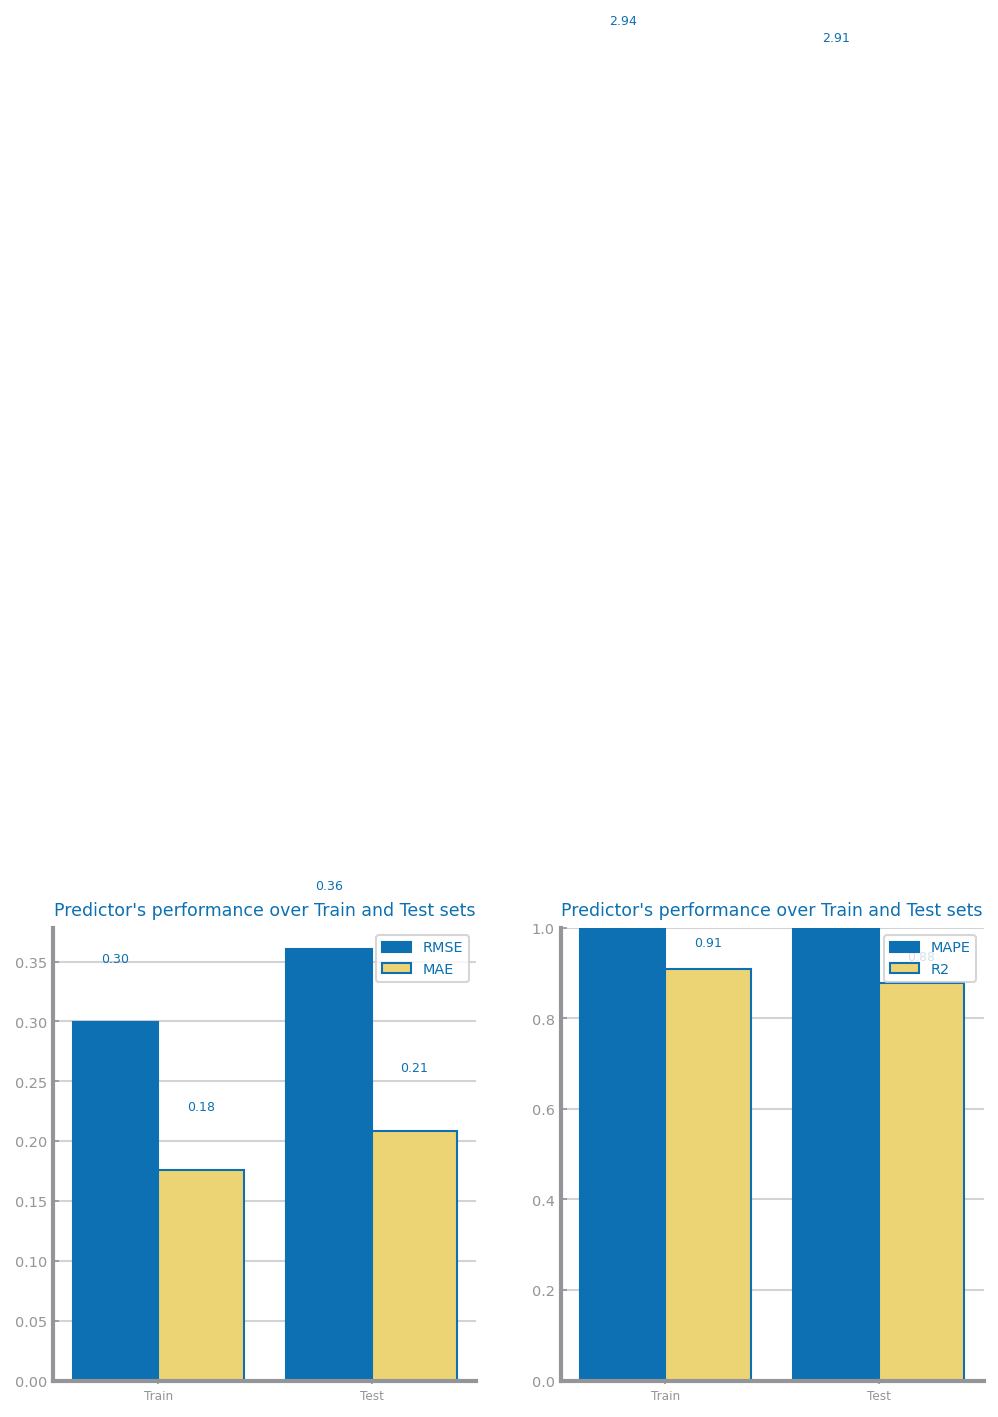

In [80]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_tree_best.png')

Like for classification, we may visualize our tree ...

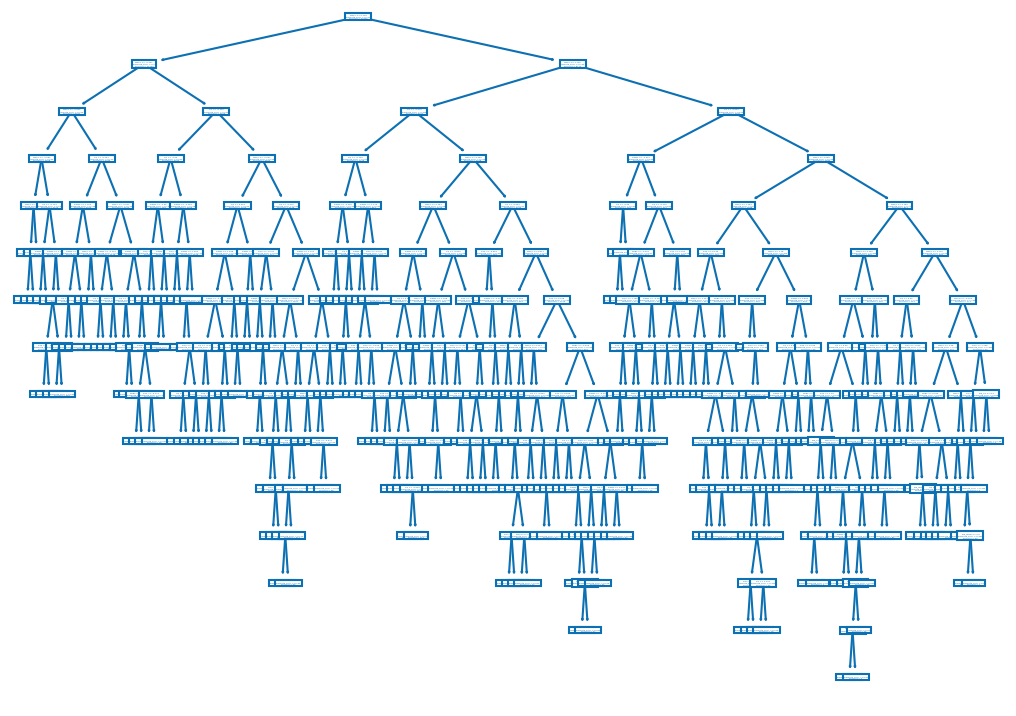

In [81]:
tree.plot_tree(best_model, feature_names=data.columns)
savefig(f'../03_images/ts_tree_best_tree.png')

and the performance of our predictor, studying its overfitting.

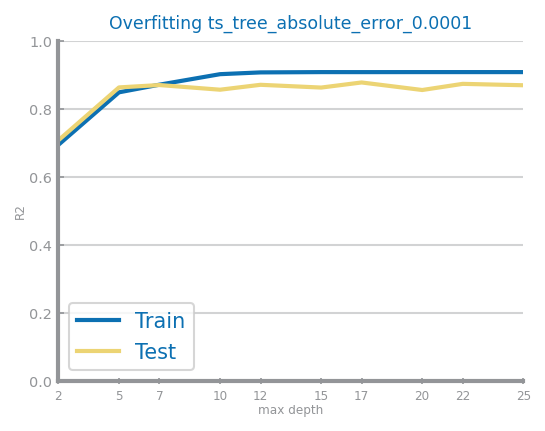

In [82]:
y_tst_values = []
y_trn_values = []
for d in max_depths:
    pred = DecisionTreeRegressor(max_depth=d, criterion=best[0], min_impurity_decrease=best[1])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(max_depths, y_trn_values, y_tst_values, name=f'ts_tree_{best[0]}_{best[1]}', xlabel='max depth', ylabel=measure, pct=flag_pct)

## 03 - Random Forests

As in classification, Random Forests, implemented through the RandomForestRegressor in the sklearn.ensemble package, are one of the most powerful prediction techniques, simple and easy to apply.

It trains a set of n regression trees, that are combined in an ensemble of n_estimators. Each tree, however, is trained over a different subset of the original training data, first by choosing a subset of k variables describing the data, with k determined by the max_features parameter. Beside many other parameters we can choose the maximum size of each tree and the splitting criteria, through max_depth and criterion parameter.

Next, we can see the results achieved by a set of parameters combinations.

In [83]:
measure = 'R2'
flag_pct = True
max_features = [.25, .75]
max_depths = [5, 10, 15, 20, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]

<Figure size 600x450 with 0 Axes>

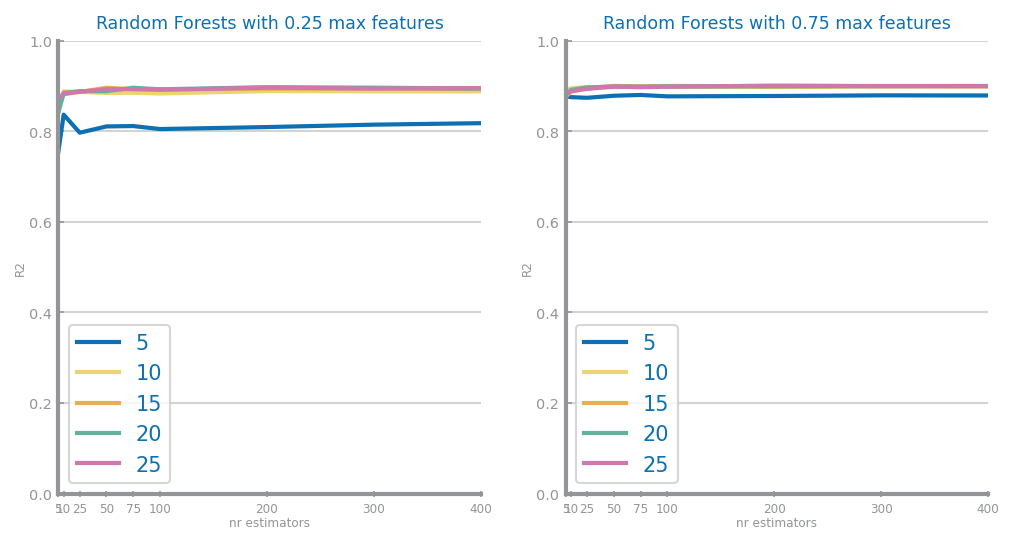

Best results achieved with 0.75 max features, depth=25 and nr estimators=200 ==> measure=0.90


In [84]:
best = ('',  0, 0.0)
last_best = 0
best_model = None
ncols = len(max_features)
figure()
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for nf in range(len(max_features)):
    f = max_features[nf]
    values = {}
    for d in max_depths:
        yvalues = []
        for n in n_estimators:
            pred = RandomForestRegressor(n_estimators=n, max_depth=d, max_features=f)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (f, d, n)
                last_best = yvalues[-1]
                best_model = pred

        values[d] = yvalues
    multiple_line_chart(
        n_estimators, values, ax=axs[0, nf], title=f'Random Forests with {f} max features', xlabel='nr estimators', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_rf_study.png')
show()
print(f'Best results achieved with {best[0]} max features, depth={best[1]} and nr estimators={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.10353723476604514, 0.32406591903453436], 'MAE': [0.059250379590339936, 0.1976629144240223]} {'MAPE': [1.7234754674073363, 2.618268765830754], 'R2': [0.9889902921688711, 0.9005854487137719]}


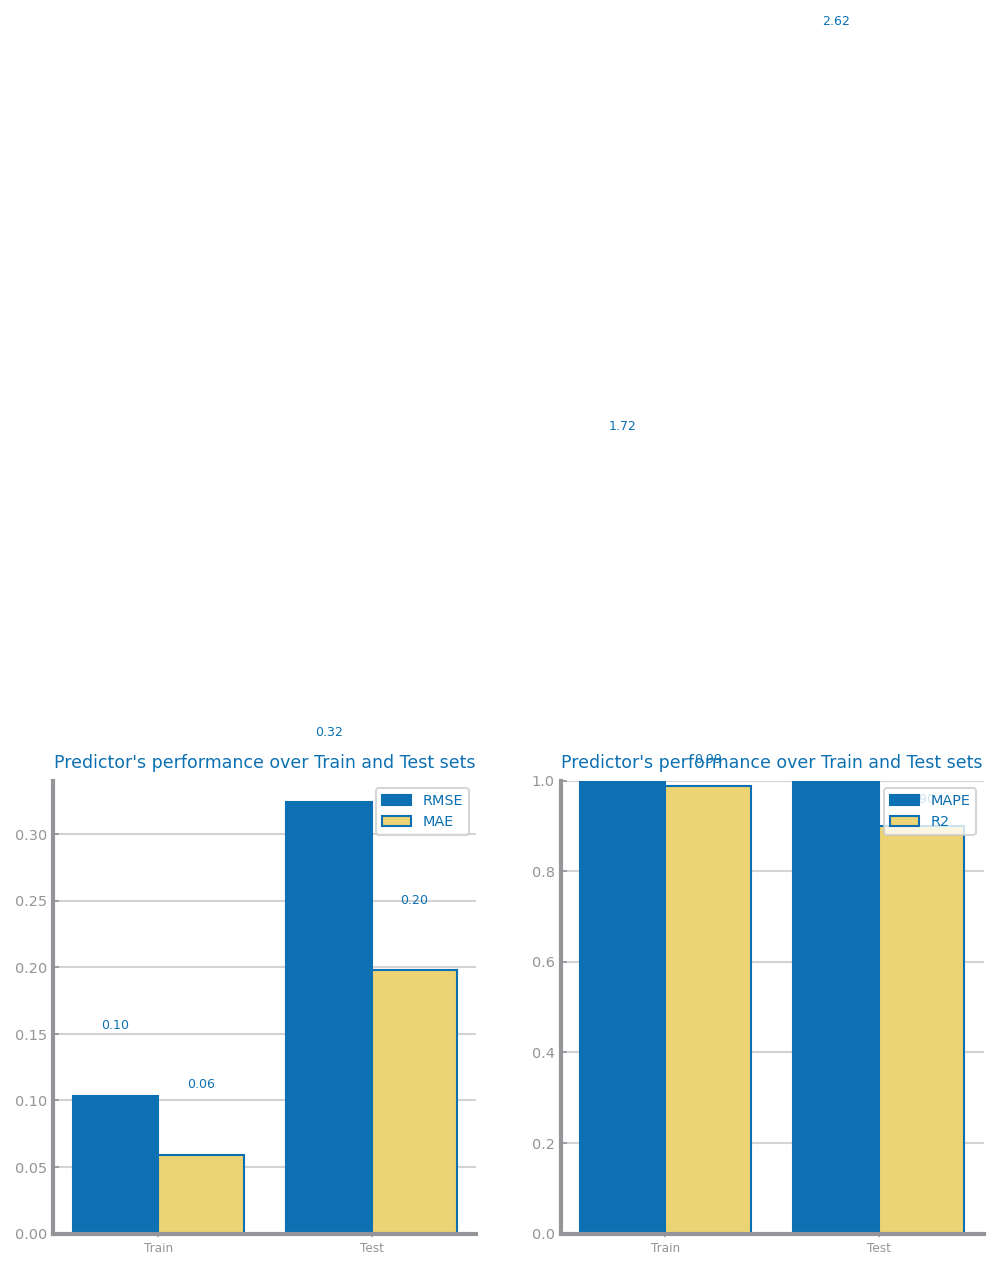

In [85]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_rf_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

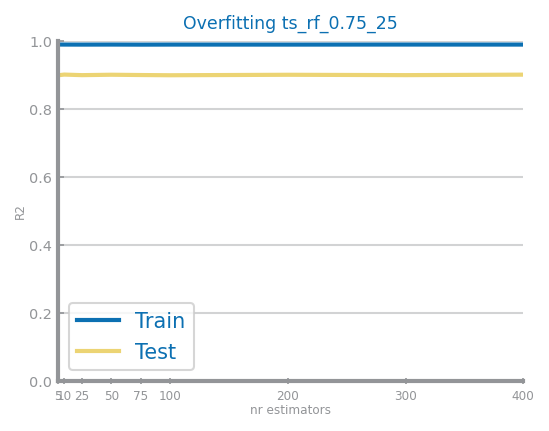

In [86]:
y_tst_values = []
y_trn_values = []
for k in n_estimators:
    pred = RandomForestRegressor(n_estimators=best[2], max_depth=best[1], max_features=best[0])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'ts_rf_{best[0]}_{best[1]}', xlabel='nr estimators', ylabel=measure, pct=flag_pct)

## 04 - GradientBoosting

As before, Gradient Boosting, implemented through the GradientBoostingRegressorr in the sklearn.ensemble package, is anoother powerful prediction technique.

Like random forests for prediction, it trains a set of n regression trees, that are combined in an ensemble of n_estimators. Each tree, however, is trained over the original dataset and usually has a fixed maximum depth. Beside many other parameters we can choose the maximum tree depth, learning rate and critirion to use, through max_depth, learning_rate and criterion parameters, respectively. And we are able to choose the Loss function to be optimized during the training, setting the parameter loss.

In [87]:
measure = 'R2'
flag_pct = True
learning_rate = [.1, .5, .9]
max_depths = [5, 10, 15, 20, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 200, 300, 400]

<Figure size 600x450 with 0 Axes>

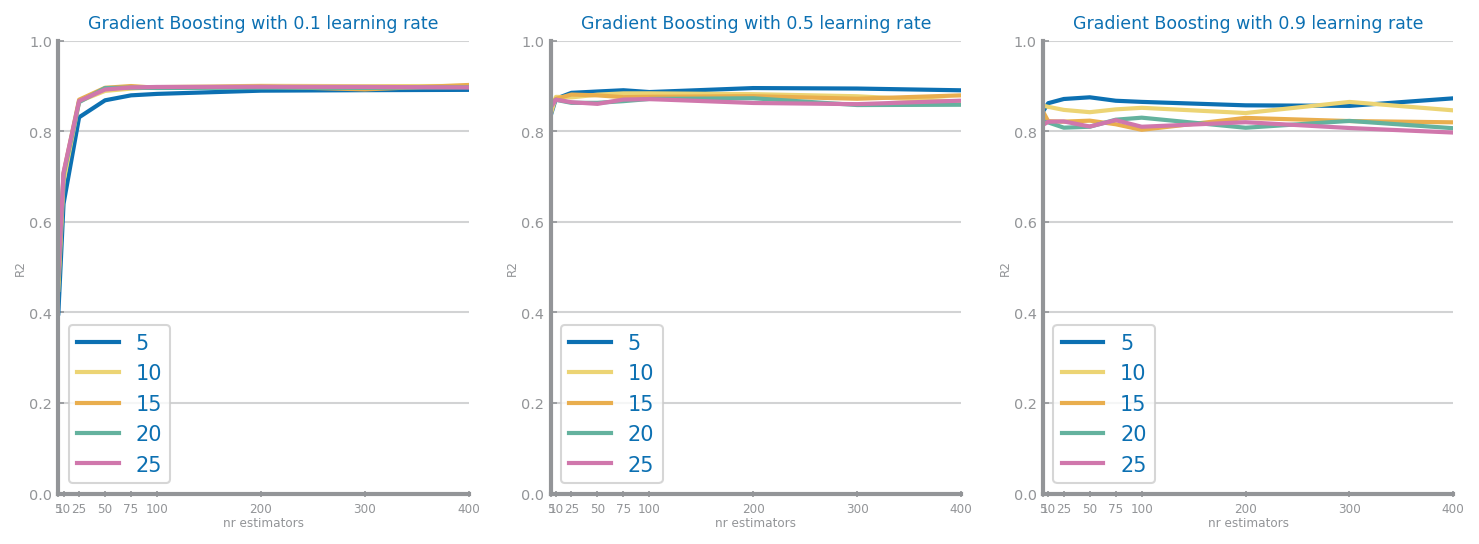

Best results achieved with 0.1 learning rate, depth=15 and nr estimators=400 ==> measure=0.90


In [88]:
best = ('',  0, 0.0)
last_best = 0
best_model = None
ncols = len(learning_rate)
figure()
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for nr_lr in range(len(learning_rate)):
    lr = learning_rate[nr_lr]
    values = {}
    for d in max_depths:
        yvalues = []
        for n in n_estimators:
            pred = GradientBoostingRegressor(n_estimators=n, max_depth=d, learning_rate=lr, loss='absolute_error')
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (lr, d, n)
                last_best = yvalues[-1]
                best_model = pred

        values[d] = yvalues
    multiple_line_chart(
        n_estimators, values, ax=axs[0, nr_lr], title=f'Gradient Boosting with {lr} learning rate', xlabel='nr estimators', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_gb_study.png')
show()
print(f'Best results achieved with {best[0]} learning rate, depth={best[1]} and nr estimators={best[2]} ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.12521079793253015, 0.3218779945629005], 'MAE': [0.040951935635640056, 0.19236416348964241]} {'MAPE': [1.2497510485116072, 2.6040357246112364], 'R2': [0.98389850369091, 0.9019233078006139]}


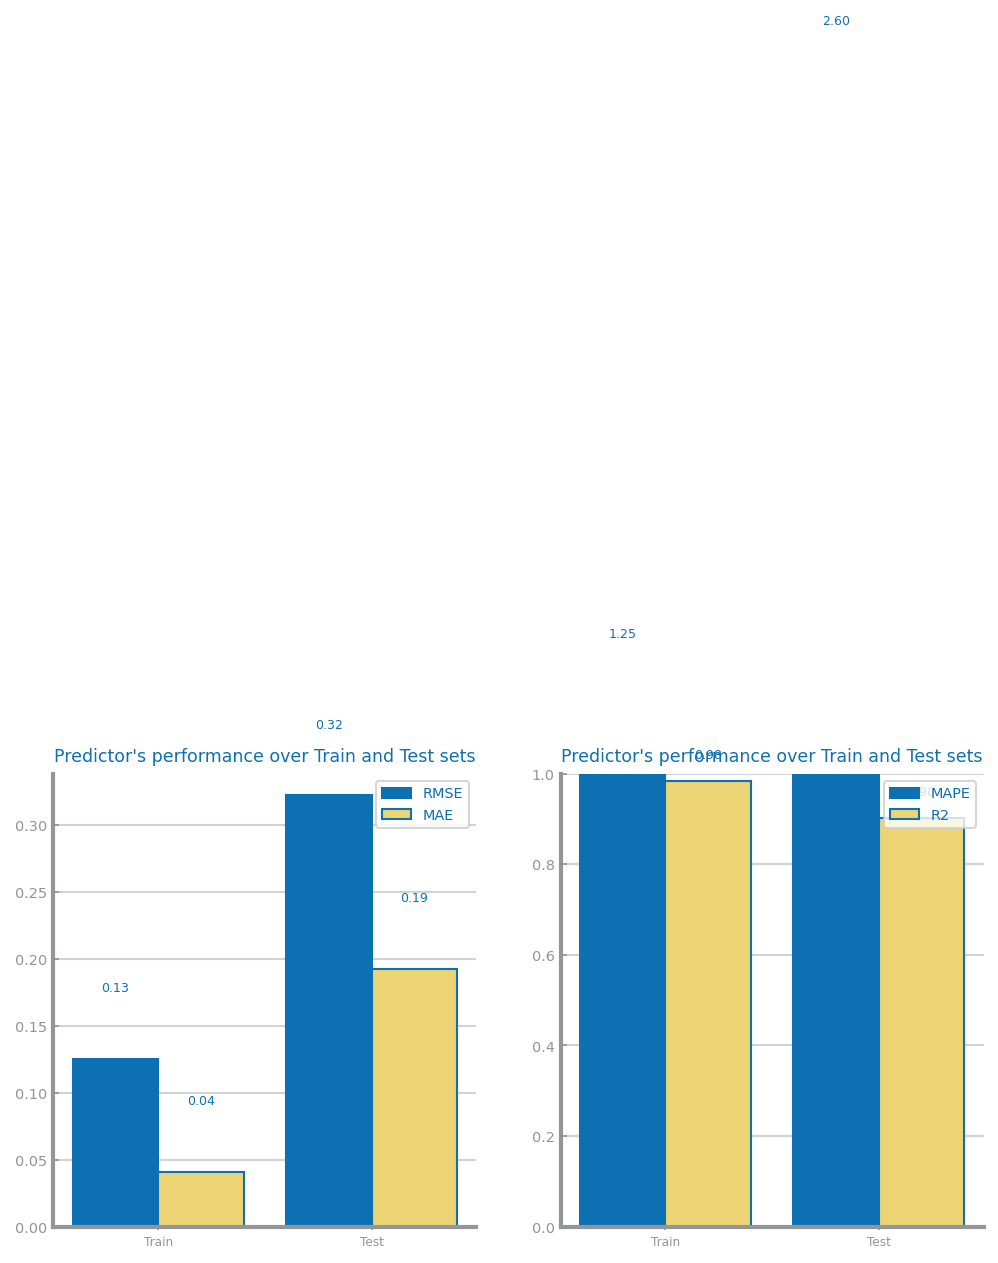

In [89]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_gb_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

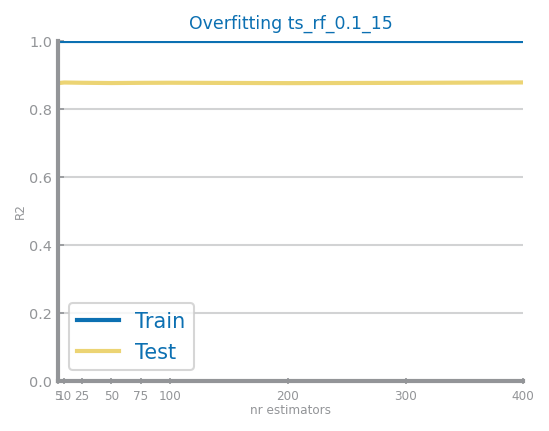

In [90]:
y_tst_values = []
y_trn_values = []
for k in n_estimators:
    pred = GradientBoostingRegressor(n_estimators=best[2], max_depth=best[1], learning_rate=best[0])
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
plot_overfitting_study(n_estimators, y_trn_values, y_tst_values, name=f'ts_rf_{best[0]}_{best[1]}', xlabel='nr estimators', ylabel=measure, pct=flag_pct)

## 05 - Multi Layer Perceptrons

Multi Layer Perceptrons are the usual representation used by neural networks for dealing with multidimensional data. In the context of prediction, in Python, they are implemented through the MLPRegressor in the sklearn.neural_network. And its use is similar for both classification and prediction.

In [91]:
lr_type = ['constant', 'invscaling', 'adaptive']
learning_rate = [.9, .6, .3, .1]
max_iter = [100, 150, 250, 500, 1000]
max_iter_warm_start = [max_iter[0]]
for el in max_iter[1:]:
    max_iter_warm_start.append(max_iter_warm_start[-1]+el)

best = ('',  0, 0.0)
last_best = 0
best_model = None

measure = 'R2'
flag_pct = True

<Figure size 600x450 with 0 Axes>

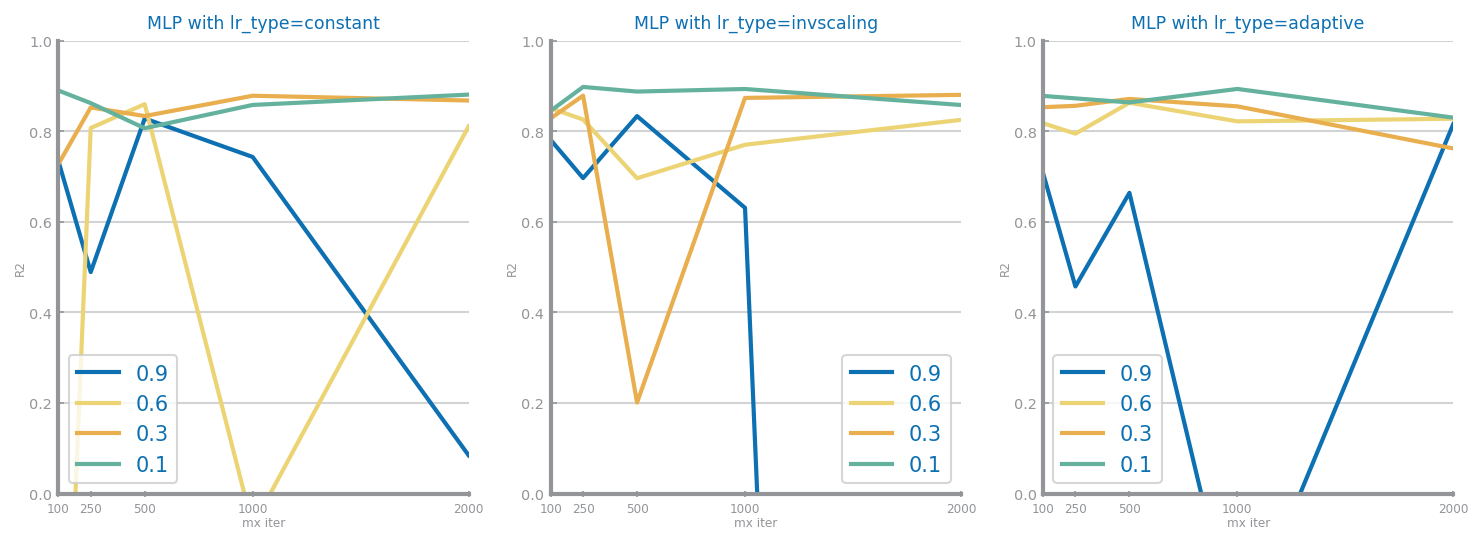

Best results with lr_type=invscaling, learning rate=0.1 and 150 max iter ==> measure=0.90


In [92]:
ncols = len(lr_type)
figure()
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(lr_type)):
    tp = lr_type[k]
    values = {}
    warm_start = False
    for lr in learning_rate:
        yvalues = []
        for n in max_iter:
            pred = MLPRegressor(
                learning_rate=tp, learning_rate_init=lr, max_iter=n,
                activation='relu', warm_start=warm_start, verbose=False)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (tp, lr, n)
                last_best = yvalues[-1]
                best_model = pred
        values[lr] = yvalues
        warm_start = True

    multiple_line_chart(
        max_iter_warm_start, values, ax=axs[0, k], title=f'MLP with lr_type={tp}', xlabel='mx iter', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_mlp_study.png')
show()
print(f'Best results with lr_type={best[0]}, learning rate={best[1]} and {best[2]} max iter ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.3335446871729845, 0.32895795639072095], 'MAE': [0.21164970071713793, 0.2073250593502116]} {'MAPE': [3.2281705222339077, 2.69182995221058], 'R2': [0.8857409193549913, 0.8975613075402425]}


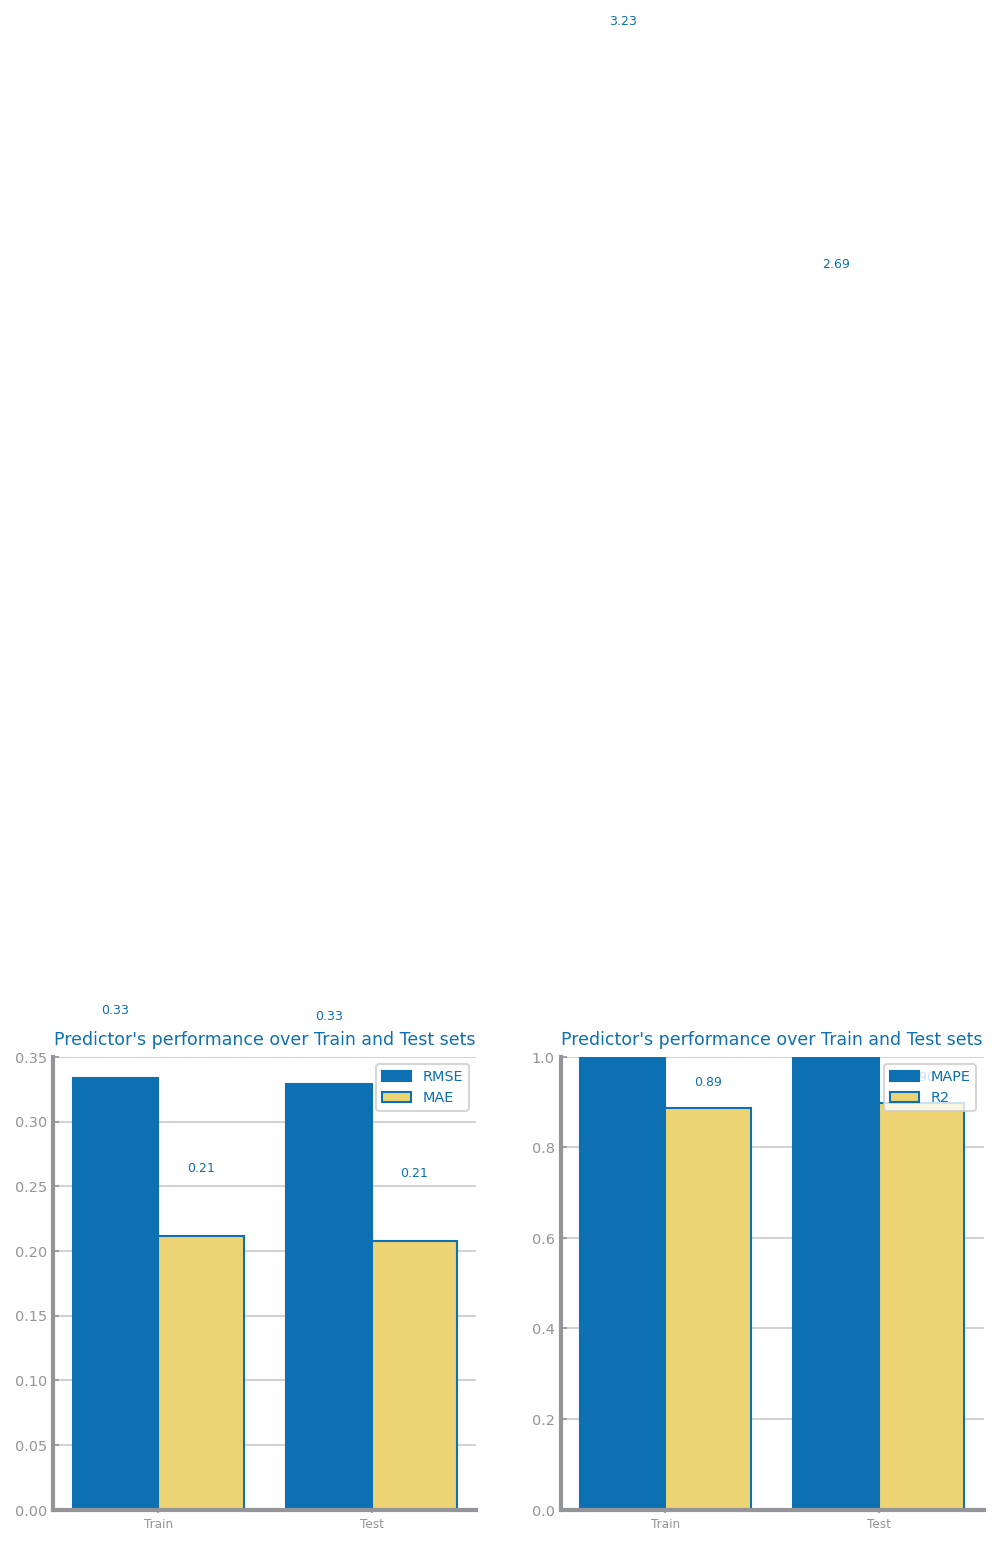

In [93]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_mlp_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

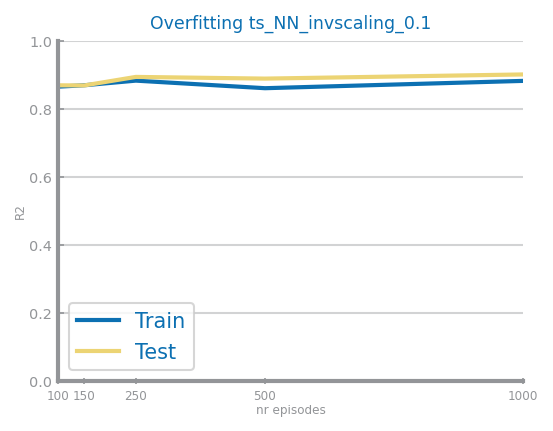

In [94]:
y_tst_values = []
y_trn_values = []
warm_start = False
for n in max_iter:
    MLPRegressor(
        learning_rate=best[0], learning_rate_init=best[1], max_iter=n, 
        activation='relu', warm_start=warm_start, verbose=False) 
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
    warm_start = True
plot_overfitting_study(max_iter, y_trn_values, y_tst_values, name=f'ts_NN_{best[0]}_{best[1]}', xlabel='nr episodes', ylabel=measure, pct=flag_pct)